In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import requests

%matplotlib inline

In [2]:
csvpath = Path("../Data/GNRC.csv")
stock_title = "Generac Holdings Inc. Stock Price Prediction Model"

In [3]:
stock_df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [4]:
# stock_df.head()

In [5]:
stock_df.sort_index(ascending=True, inplace=True)

In [6]:
stock_df = stock_df.rename(columns={"Close/Last": "Close"})

In [7]:
stock_df = stock_df[['Close']]
# stock_df

In [8]:
stock_df['Close'] = stock_df['Close'].str.replace('$', '').astype(float)

In [9]:
# stock_df

In [10]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window- 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [11]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(stock_df, window_size, feature_column, target_column)

In [12]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [13]:
# y_train

In [14]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Scale the y_test data
X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [15]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = window_size
# 20% of neurons to be dropped out
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [18]:
model.compile(optimizer="adam", loss="mean_squared_error")
# model.summary()

In [19]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=0)

Epoch 1/20
15/15 [==============================] - 32s 630ms/step - loss: 0.0106
Epoch 2/20
15/15 [==============================] - 9s 629ms/step - loss: 0.0113
Epoch 3/20
15/15 [==============================] - 8s 555ms/step - loss: 0.0103
Epoch 4/20
15/15 [==============================] - 8s 505ms/step - loss: 0.0184
Epoch 5/20
15/15 [==============================] - 7s 490ms/step - loss: 0.0258
Epoch 6/20
15/15 [==============================] - 6s 409ms/step - loss: 0.0252
Epoch 7/20
15/15 [==============================] - 6s 418ms/step - loss: 0.0186
Epoch 8/20
15/15 [==============================] - 6s 428ms/step - loss: 0.0066
Epoch 9/20
15/15 [==============================] - 6s 414ms/step - loss: 0.0053
Epoch 10/20
15/15 [==============================] - 8s 509ms/step - loss: 0.0040
Epoch 11/20
15/15 [==============================] - 8s 510ms/step - loss: 0.0061
Epoch 12/20
15/15 [==============================] - 9s 581ms/step - loss: 0.0040
Epoch 13/20
15/15 [=====

In [20]:
model.evaluate(X_test, y_test, verbose=0)

2.231297731399536

In [21]:
predicted = model.predict(X_test)

In [22]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [23]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [24]:
stock_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = stock_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
# stock_actual_predicted.head()

In [25]:
# stock_actual_predicted.tail()

<AxesSubplot:title={'center':'Generac Holdings Inc. Stock Price Prediction Model'}, xlabel='Date', ylabel='Price'>

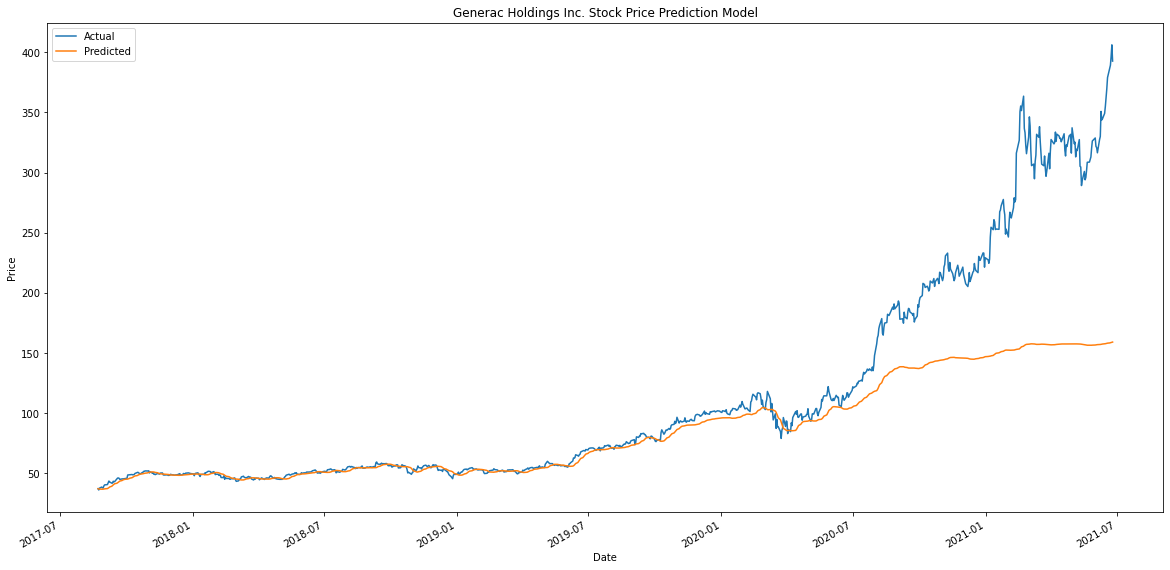

In [26]:
stock_actual_predicted.plot(figsize=(20,10), ylabel="Price", title=stock_title)